In [104]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import PIL
import os

In [106]:
# import each path of the image classes
cataract = Path('/content/drive/MyDrive/dataset/cataract')
diabetic_retinopathy = Path('/content/drive/MyDrive/dataset/diabetic_retinopathy')
glaucoma = Path('/content/drive/MyDrive/dataset/glaucoma')
normal = Path('/content/drive/MyDrive/dataset/normal')

In [107]:
# creating dataframe with filepath and labels
from tqdm import tqdm
disease_type = [cataract,diabetic_retinopathy,glaucoma,normal]
df = pd.DataFrame()
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

/content/drive/MyDrive/dataset/cataract: 100%|██████████| 1038/1038 [00:00<00:00, 1915.89it/s]
/content/drive/MyDrive/dataset/diabetic_retinopathy: 100%|██████████| 1098/1098 [00:00<00:00, 1897.23it/s]
/content/drive/MyDrive/dataset/normal: 100%|██████████| 1074/1074 [00:00<00:00, 1778.25it/s]


In [108]:
df

image  disease_type
0     /content/drive/MyDrive/dataset/cataract/2099_l...             0
1     /content/drive/MyDrive/dataset/cataract/1454_r...             0
2     /content/drive/MyDrive/dataset/cataract/119_le...             0
3     /content/drive/MyDrive/dataset/cataract/1968_l...             0
4     /content/drive/MyDrive/dataset/cataract/2103_l...             0
...                                                 ...           ...
4212  /content/drive/MyDrive/dataset/normal/2418_lef...             3
4213  /content/drive/MyDrive/dataset/normal/2421_rig...             3
4214  /content/drive/MyDrive/dataset/normal/2421_lef...             3
4215  /content/drive/MyDrive/dataset/normal/2408_lef...             3
4216  /content/drive/MyDrive/dataset/normal/2396_lef...             3

[4217 rows x 2 columns]

In [109]:
def plot_image(n, num_samples=3):
    disease_labels = ['cataract','diabetic_retinopathy','glaucoma','normal']
    images = df[df['disease_type'] == n].sample(num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.show()

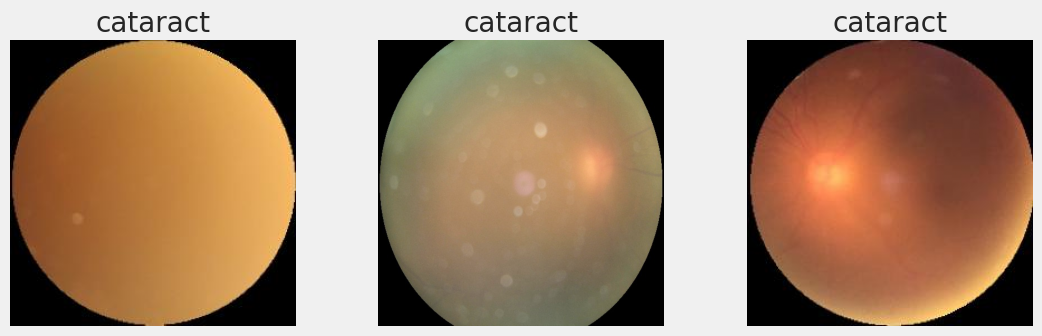

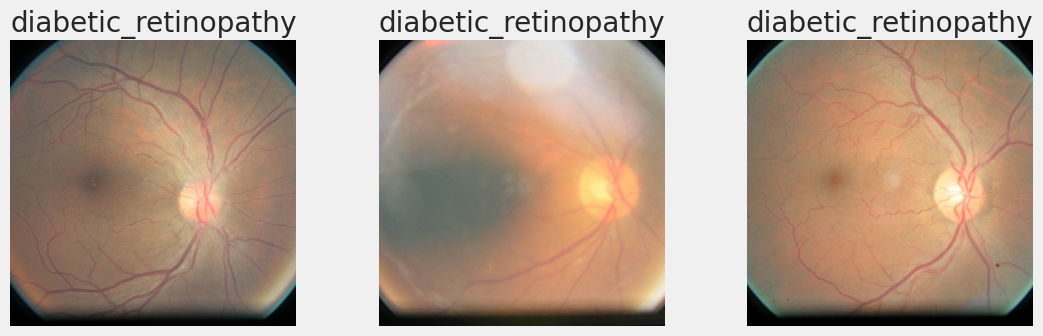

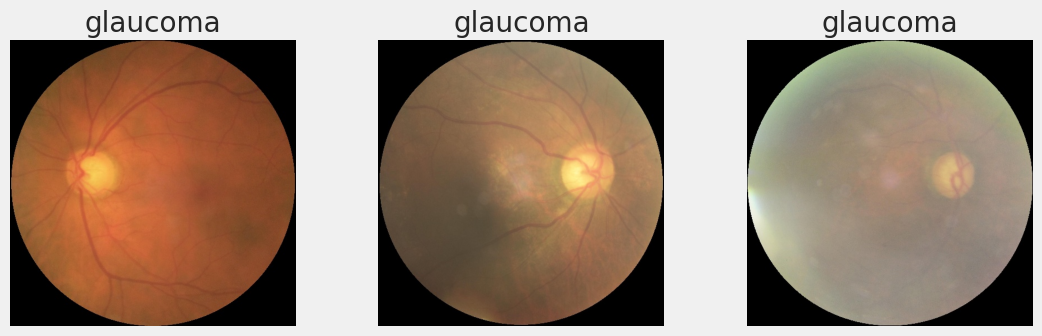

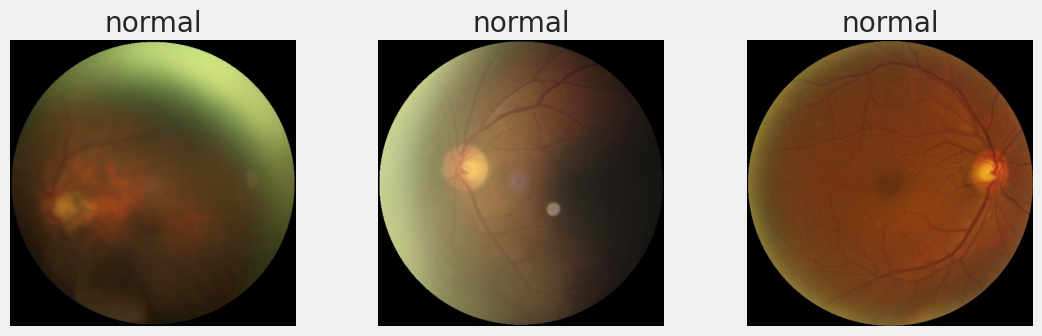

In [110]:
plot_image(0)
plot_image(1)
plot_image(2)
plot_image(3)

In [111]:
df['disease_type'] = df['disease_type'].map({0:'cataract',1:'diabetic_retinopathy',2:'glaucoma',3:'normal'})

In [112]:
df.disease_type.value_counts()

diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: disease_type, dtype: int64

In [113]:
# shuffling the rows of a DataFrame df
df1=df.sample(frac=1).reset_index(drop=True)

<ipython-input-114-7cc01bdac1ac>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='disease_type', data=df1, palette=custom_palette)


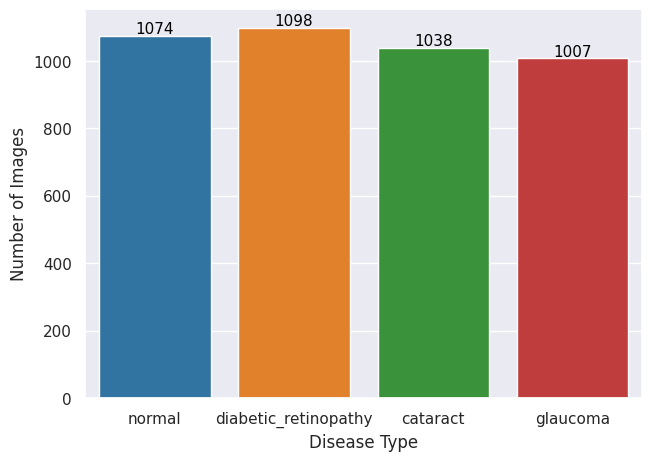

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df1' is your DataFrame and it contains a column 'disease_type' with the categories
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
sns.set(style="darkgrid")
ax = sns.countplot(x='disease_type', data=df1, palette=custom_palette)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Set the labels and title
plt.xlabel('Disease Type')
plt.ylabel('Number of Images')

# Save the plot to a file
plt.savefig('/content/drive/MyDrive/OCULAR_DISEASE/model_files/countplot.png')

# Display the plot
plt.show()


# DATA PREPROCESSING

In [115]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,BatchNormalization,MaxPooling2D,Conv2DTranspose,Activation
, Input,concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Add, DepthwiseConv2D,Flatten
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory

In [116]:
from sklearn.model_selection import train_test_split
# Splitting data into features (X) and labels (y)
X = df1['image']  # 'image' contains image data
y = df1['disease_type']  # 'disease_type' contains labels
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [118]:
# Data generators for training
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          subset = 'training')

Found 3374 validated image filenames belonging to 4 classes.


In [119]:
# Data generators for validation
valid_data=datagen.flow_from_dataframe(dataframe=df1,
                                      x_col='image',
                                      y_col = 'disease_type',
                                      target_size = (224,224),
                                      class_mode= 'categorical',
                                      batch_size = 32,
                                      shuffle = False,
                                      subset= 'validation')

Found 843 validated image filenames belonging to 4 classes.


In [120]:
# Check if class indices are consistent
if (train_data.class_indices == valid_data.class_indices):
    print("Class indices are consistent")
    class_indices = train_data.class_indices
    print(class_indices)
    js_code = f"const classIndices = {class_indices};\nexport default classIndices;"
    with open('metadata.js', 'w') as f:
        f.write(js_code)
else:
    print("Class indices are not consistent")

Class indices are consistent
{'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}


# MOBILENETV2

In [128]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)

# Load MobileNetV2 model with pre-trained weights (excluding the top layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding your custom layers on top of the MobileNetV2 base
x = layers.Flatten()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [129]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

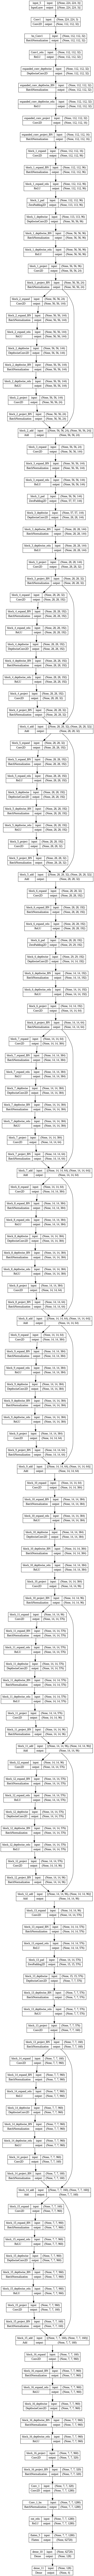

In [130]:
tf.keras.utils.plot_model(model,
                          to_file="/content/drive/MyDrive/OCULAR_DISEASE/model_files/MobileNetV2/Mnet_model.png",
                          show_shapes=True,
                          expand_nested=True)

In [131]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("/content/drive/MyDrive/OCULAR_DISEASE/model_files/MobileNetV2/MNet_model.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [132]:
history = model.fit(
    train_data,
    batch_size=32,
    epochs=30,
    validation_data=valid_data,
    verbose=1,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/30
106/106 [==============================] - ETA: 0s - loss: 3.2412 - accuracy: 0.6043
Epoch 1: val_accuracy improved from -inf to 0.77224, saving model to /content/drive/MyDrive/OCULAR_DISEASE/model_files/MobileNetV2/MNet_model.h5
106/106 [==============================] - 40s 354ms/step - loss: 3.2412 - accuracy: 0.6043 - val_loss: 0.6254 - val_accuracy: 0.7722
Epoch 2/30
106/106 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.8074
Epoch 2: val_accuracy improved from 0.77224 to 0.79597, saving model to /content/drive/MyDrive/OCULAR_DISEASE/model_files/MobileNetV2/MNet_model.h5
106/106 [==============================] - 37s 354ms/step - loss: 0.4947 - accuracy: 0.8074 - val_loss: 0.4960 - val_accuracy: 0.7960
Epoch 3/30
106/106 [==============================] - ETA: 0s - loss: 0.3071 - accuracy: 0.8817
Epoch 3: val_accuracy improved from 0.79597 to 0.80427, saving model to /content/drive/MyDrive/OCULAR_DISEASE/model_files/MobileNetV2/MNet_model.h5
106

In [133]:
# Load the saved best model
best_model = tf.keras.models.load_model('/content/drive/MyDrive/OCULAR_DISEASE/model_files/MobileNetV2/MNet_model.h5')

# Evaluate the best model
loss, accuracy = best_model.evaluate(valid_data)

# Print the results for the best model
print("Best Model Loss:", loss)
print("Best Model Accuracy:", accuracy)


27/27 [==============================] - 8s 260ms/step - loss: 0.5323 - accuracy: 0.8505
Best Model Loss: 0.5322883725166321
Best Model Accuracy: 0.8505337834358215


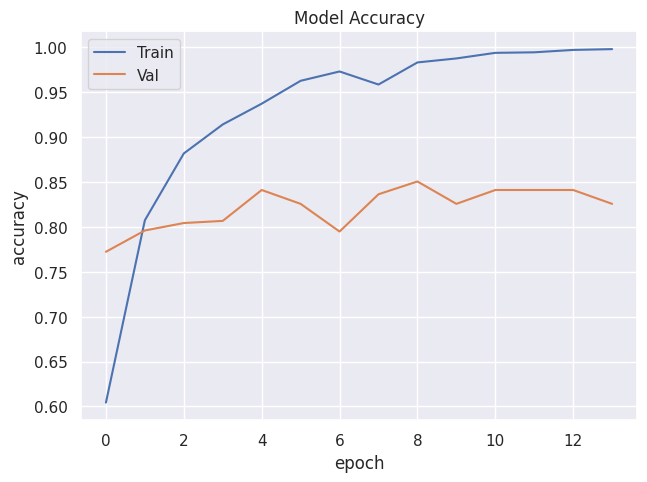

In [134]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

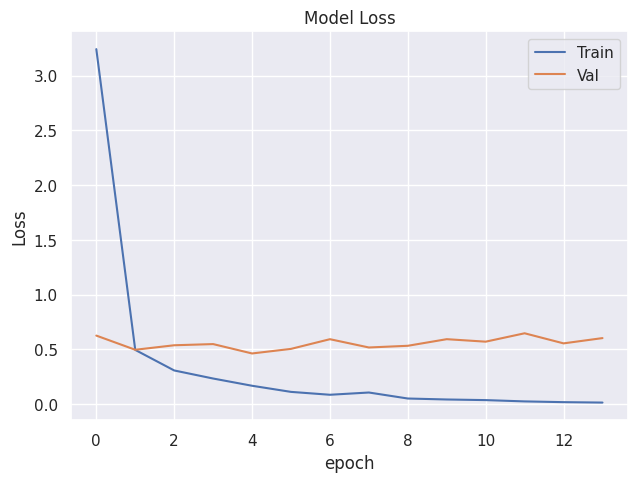

In [135]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [136]:
def tr_plot(tr_data, start_epoch):
    #Plot the loss and accuracy curve
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout

    plt.show()

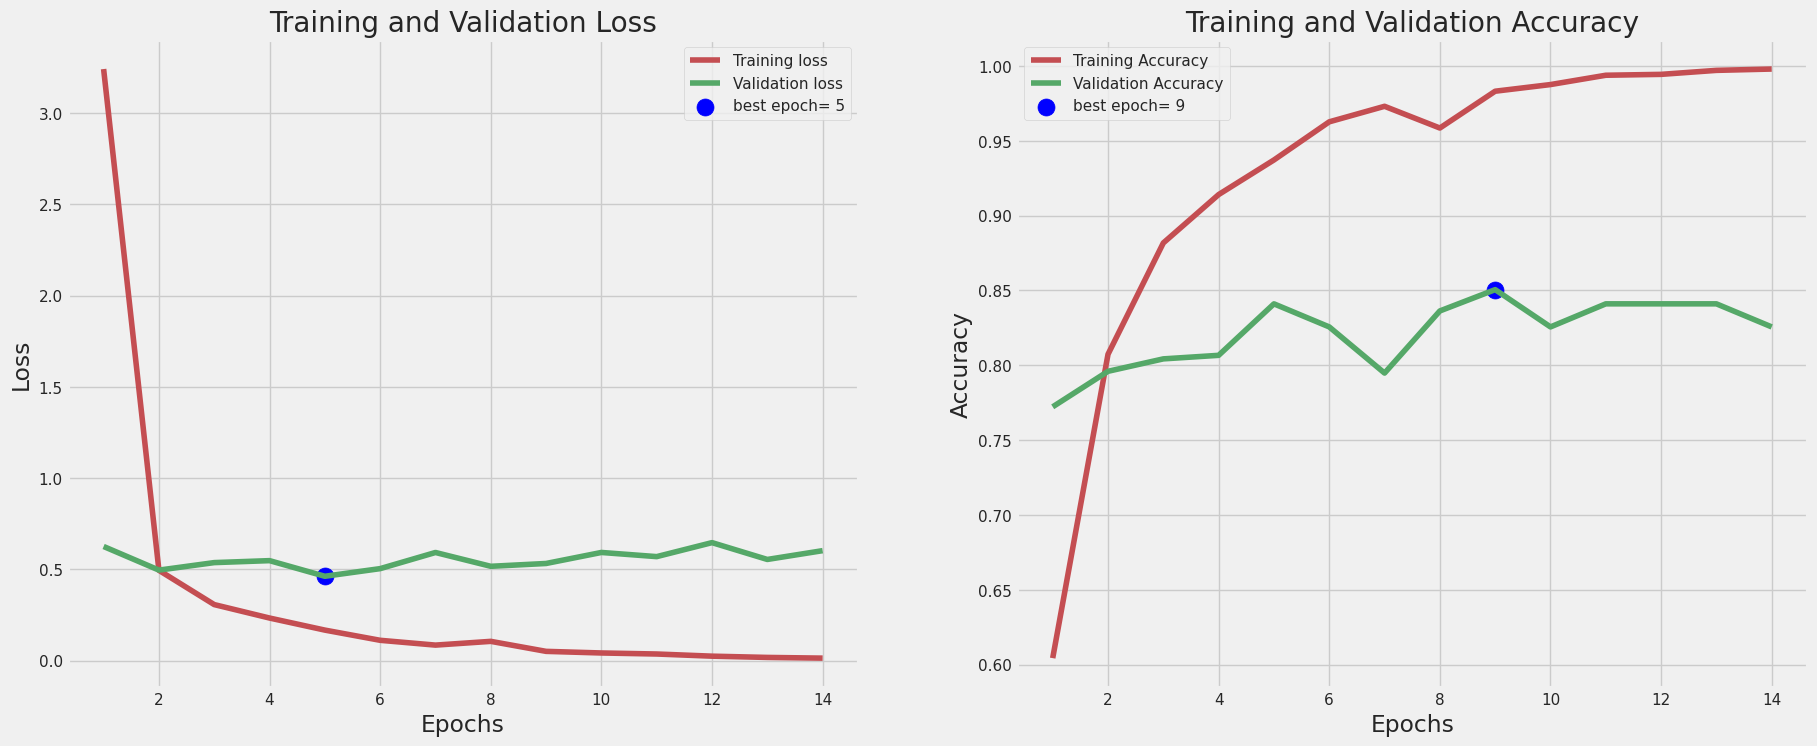

<Figure size 640x480 with 0 Axes>

In [137]:
# plot the history
tr_plot(history,0)
plt.savefig('/content/drive/MyDrive/OCULAR_DISEASE/model_files/MobileNetV2/MNet_history.png')


# MOBILENETV2 EVALUATION

In [138]:
y_test = valid_data.classes
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred,axis=1)

27/27 [==============================] - 8s 266ms/step


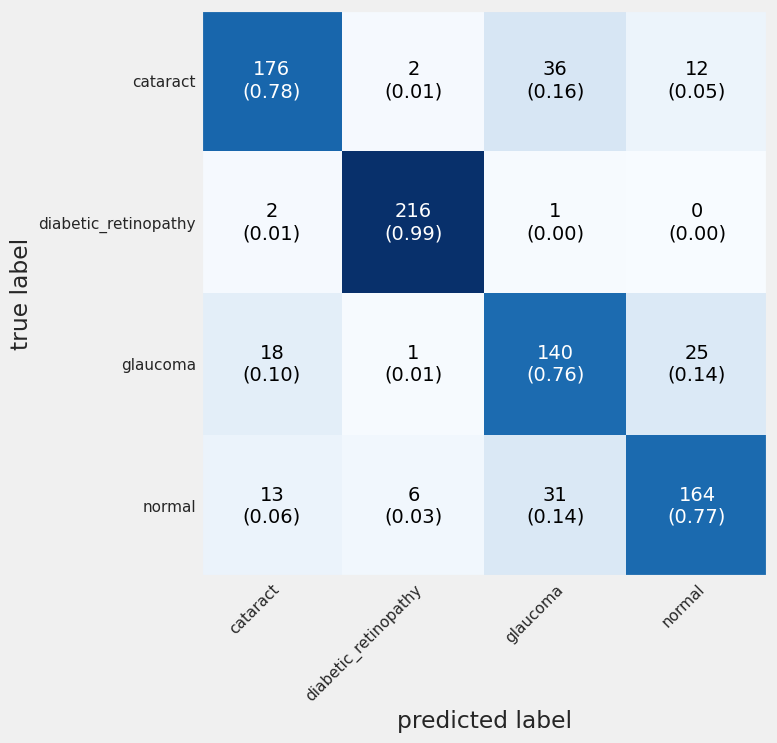

In [139]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"],
                      show_normed = True);
plt.savefig("/content/drive/MyDrive/OCULAR_DISEASE/model_files/MobileNetV2/MobileNet Predected & True Label")

In [140]:
print(classification_report(y_test,y_pred,target_names = labels))

                      precision    recall  f1-score   support

            cataract       0.84      0.78      0.81       226
diabetic_retinopathy       0.96      0.99      0.97       219
            glaucoma       0.67      0.76      0.71       184
              normal       0.82      0.77      0.79       214

            accuracy                           0.83       843
           macro avg       0.82      0.82      0.82       843
        weighted avg       0.83      0.83      0.83       843



1/1 [==============================] - 1s 771ms/step


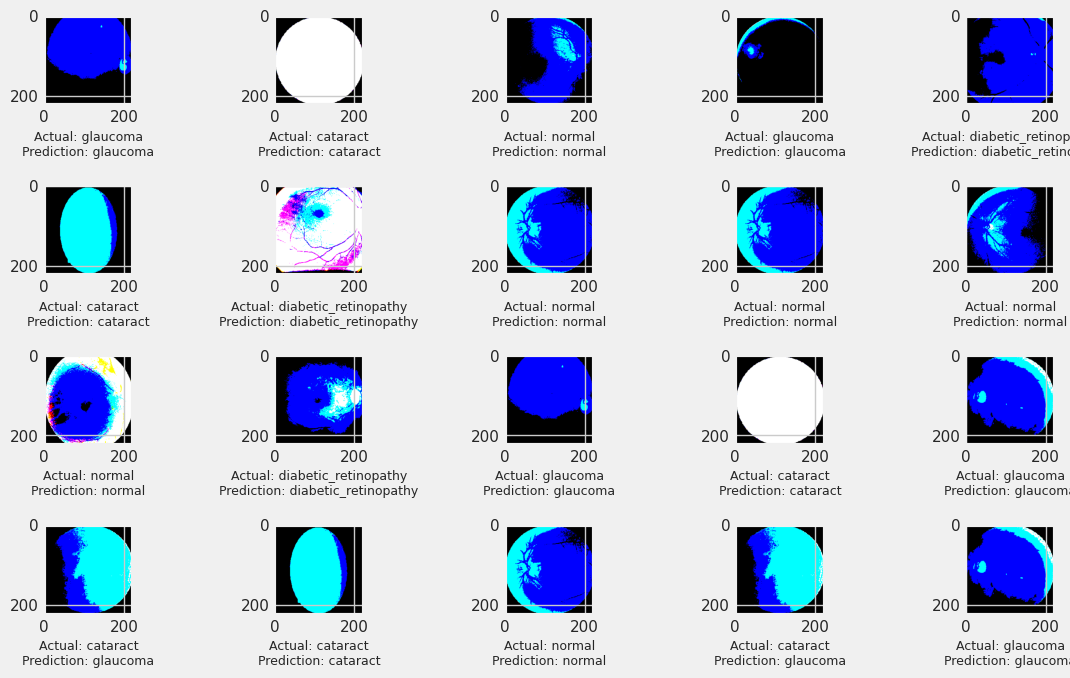

In [141]:
import random
import matplotlib.pyplot as plt

# Define the class labels
class_labels = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]
# Get a batch of data from the valid_data generator
images, labels = next(valid_data)


y_pred = model.predict(images)

plt.figure(figsize=(12, 7))

for i in range(20):
    sample_index = random.randint(0, images.shape[0] - 1)
    image = images[sample_index]
    category_index = labels[sample_index].argmax()
    pred_category_index = y_pred[sample_index].argmax()

    label = class_labels[category_index]
    pred_label = class_labels[pred_category_index]

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)


    plt.xlabel("Actual: {}\nPrediction: {}".format(label, pred_label), fontsize=9)

plt.tight_layout()

# Save the plot as an image
plt.savefig('/content/drive/MyDrive/OCULAR_DISEASE/model_files/MobileNetV2/Mnet_Model_Eval.png')

plt.show()

# EFFICIENT CNN

In [142]:
labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)

model1 = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(224,224, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

In [143]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)       

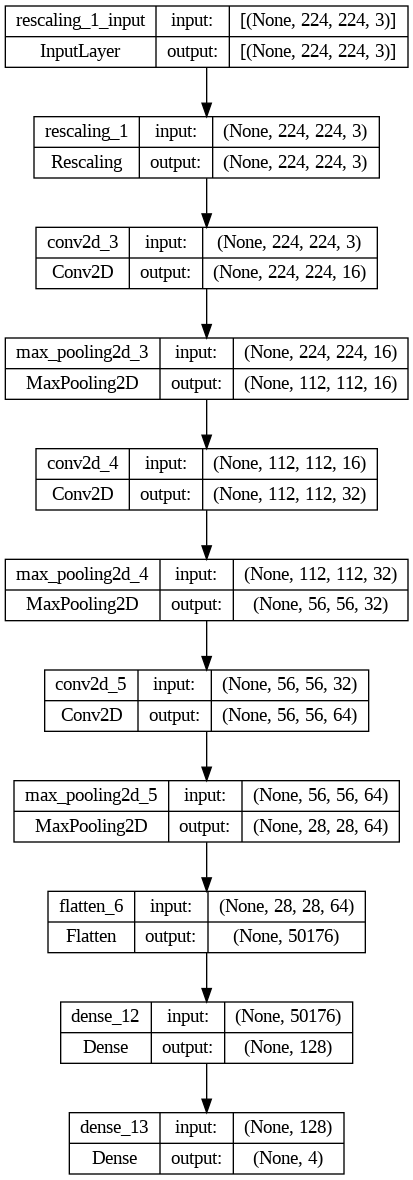

In [144]:
tf.keras.utils.plot_model(model1,
                          to_file="/content/drive/MyDrive/OCULAR_DISEASE/model_files/EFFICIENT_CNN/EFFCNN_model.png",
                          show_shapes=True,
                          expand_nested=True)

In [145]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("/content/drive/MyDrive/OCULAR_DISEASE/model_files/EFFICIENT_CNN/EFFCNN_model.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [146]:
history1 = model1.fit(
    train_data,
    batch_size=32,
    epochs=30,
    validation_data=valid_data,
    verbose=1,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/30
106/106 [==============================] - ETA: 0s - loss: 0.8321 - accuracy: 0.6363
Epoch 1: val_accuracy improved from -inf to 0.68209, saving model to /content/drive/MyDrive/OCULAR_DISEASE/model_files/EFFICIENT_CNN/EFFCNN_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


106/106 [==============================] - 38s 342ms/step - loss: 0.8321 - accuracy: 0.6363 - val_loss: 0.7620 - val_accuracy: 0.6821
Epoch 2/30
106/106 [==============================] - ETA: 0s - loss: 0.5148 - accuracy: 0.7908
Epoch 2: val_accuracy improved from 0.68209 to 0.78529, saving model to /content/drive/MyDrive/OCULAR_DISEASE/model_files/EFFICIENT_CNN/EFFCNN_model.h5
106/106 [==============================] - 36s 343ms/step - loss: 0.5148 - accuracy: 0.7908 - val_loss: 0.5542 - val_accuracy: 0.7853
Epoch 3/30
106/106 [==============================] - ETA: 0s - loss: 0.4310 - accuracy: 0.8293
Epoch 3: val_accuracy improved from 0.78529 to 0.84698, saving model to /content/drive/MyDrive/OCULAR_DISEASE/model_files/EFFICIENT_CNN/EFFCNN_model.h5
106/106 [==============================] - 36s 339ms/step - loss: 0.4310 - accuracy: 0.8293 - val_loss: 0.4336 - val_accuracy: 0.8470
Epoch 4/30
106/106 [==============================] - ETA: 0s - loss: 0.3781 - accuracy: 0.8444
Epoch 

In [147]:
# Load the saved best model
best_model = tf.keras.models.load_model('/content/drive/MyDrive/OCULAR_DISEASE/model_files/EFFICIENT_CNN/EFFCNN_model.h5')

# Evaluate the best model
loss, accuracy = best_model.evaluate(valid_data)

# Print the results for the best model
print("Best Model Loss:", loss)
print("Best Model Accuracy:", accuracy)


27/27 [==============================] - 7s 265ms/step - loss: 0.4735 - accuracy: 0.8802
Best Model Loss: 0.4735395312309265
Best Model Accuracy: 0.8801897764205933


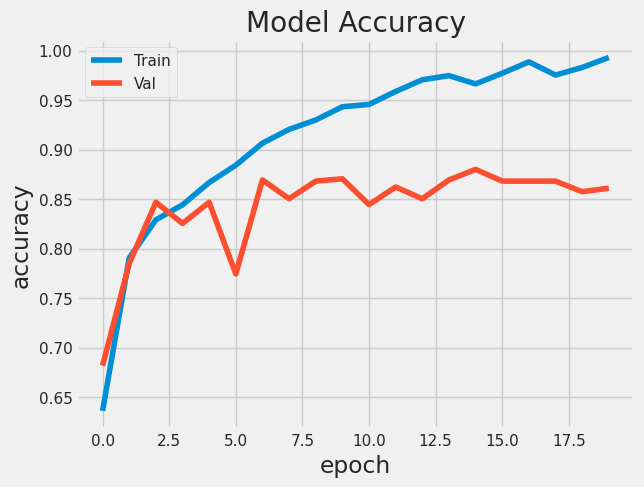

In [148]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

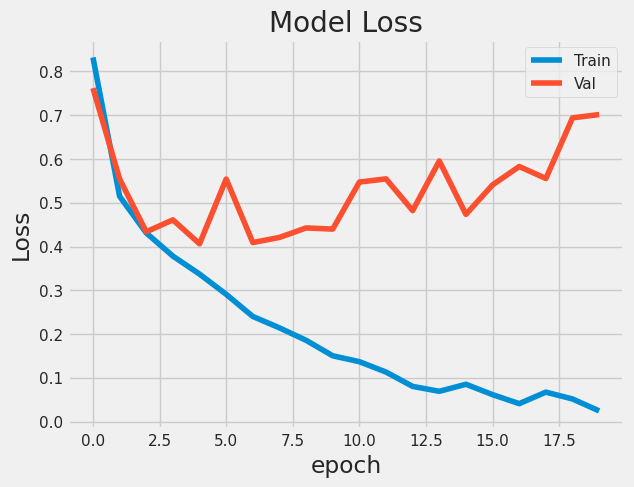

In [149]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

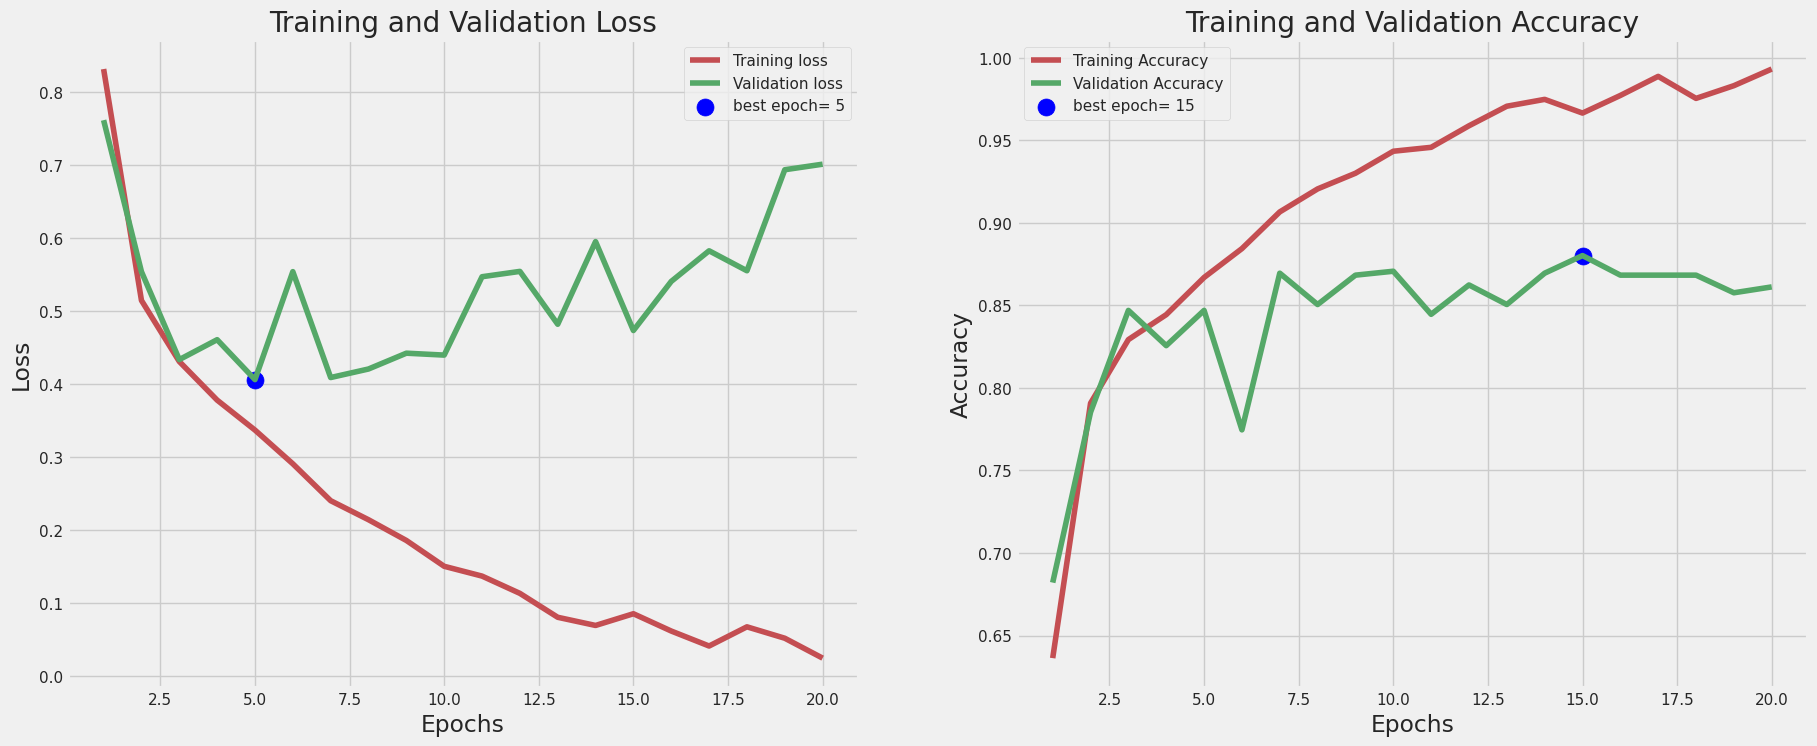

<Figure size 640x480 with 0 Axes>

In [150]:
# plot the history
tr_plot(history1,0)
plt.savefig('/content/drive/MyDrive/OCULAR_DISEASE/model_files/EFFICIENT_CNN/EFFCNN_history.png')


# EFFICIENT CNN EVALUATION

In [151]:
y_test = valid_data.classes
y_pred1 = model1.predict(valid_data)
y_pred1 = np.argmax(y_pred1,axis=1)

27/27 [==============================] - 7s 261ms/step


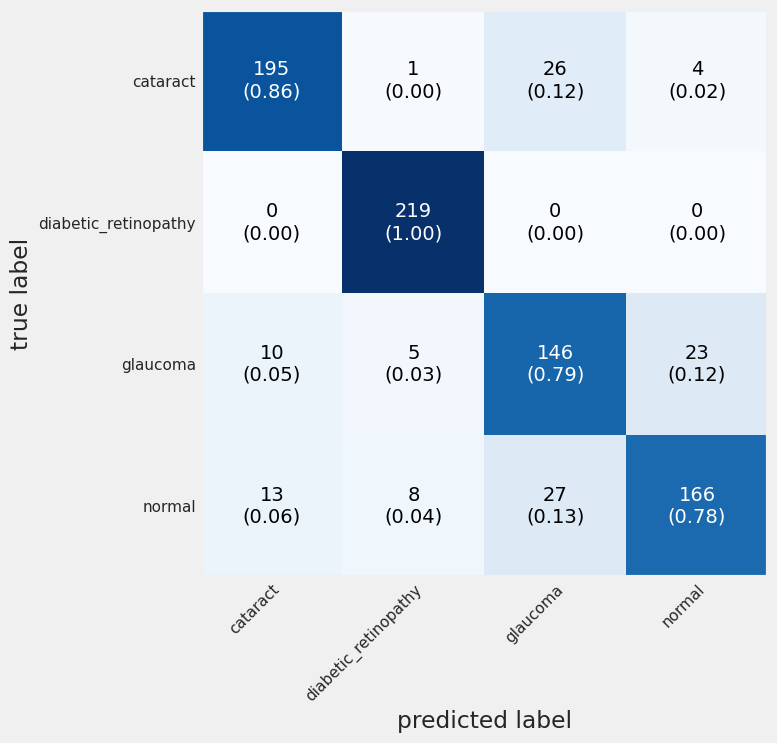

In [152]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred1)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"],
                      show_normed = True);
plt.savefig("/content/drive/MyDrive/OCULAR_DISEASE/model_files/EFFICIENT_CNN/EFFCNN Predected & True Label")

In [153]:
print(classification_report(y_test,y_pred1,target_names = labels))

                      precision    recall  f1-score   support

            cataract       0.89      0.86      0.88       226
diabetic_retinopathy       0.94      1.00      0.97       219
            glaucoma       0.73      0.79      0.76       184
              normal       0.86      0.78      0.82       214

            accuracy                           0.86       843
           macro avg       0.86      0.86      0.86       843
        weighted avg       0.86      0.86      0.86       843



1/1 [==============================] - 0s 85ms/step


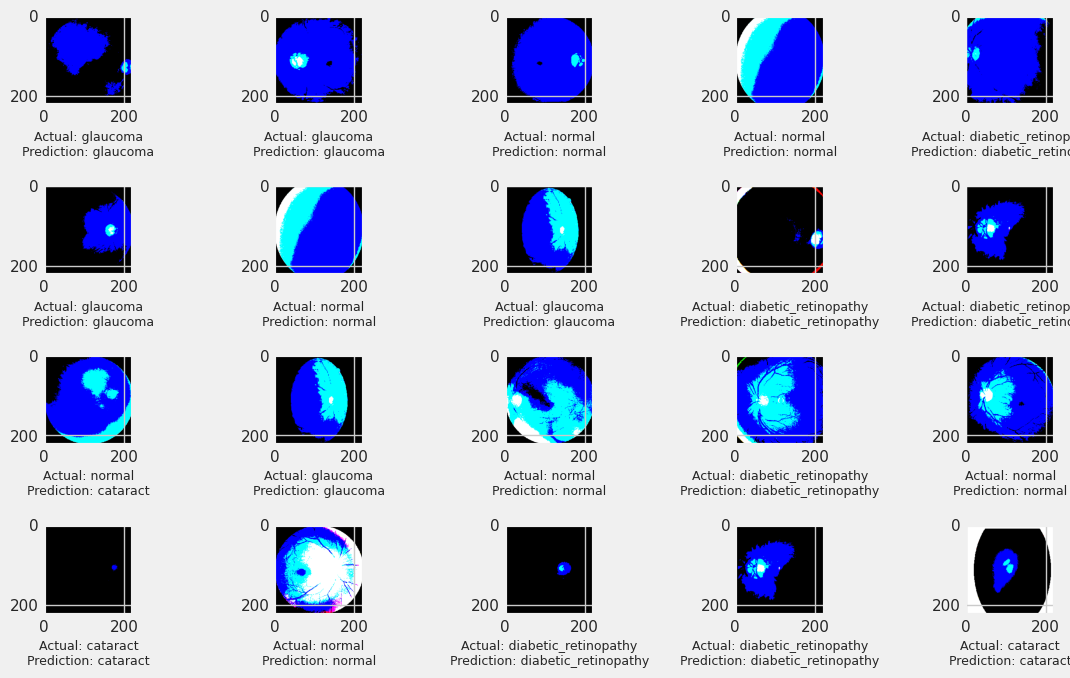

In [154]:
import random
import matplotlib.pyplot as plt


class_labels = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

images, labels = next(valid_data)


y_pred1 = model1.predict(images)

plt.figure(figsize=(12, 7))

for i in range(20):
    sample_index = random.randint(0, images.shape[0] - 1)
    image = images[sample_index]
    category_index = labels[sample_index].argmax()
    pred_category_index = y_pred1[sample_index].argmax()

    label = class_labels[category_index]
    pred_label = class_labels[pred_category_index]

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)


    plt.xlabel("Actual: {}\nPrediction: {}".format(label, pred_label), fontsize=9)

plt.tight_layout()


plt.savefig('/content/drive/MyDrive/OCULAR_DISEASE/model_files/EFFICIENT_CNN/EFFCNN_Model_Eval.png')

plt.show()

# VGG19

In [155]:
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip
from keras.models import Sequential
from tensorflow.keras.applications.vgg19 import VGG19
labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)
image_size=224
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))
for layer in vgg.layers:
    layer.trainable = False


In [156]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense

model2 = Sequential()
model2.add(vgg)
model2.add(Flatten())
model2.add(Dense(256,activation = "relu"))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(Dense(num_classes,activation="softmax"))

In [157]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_14 (Dense)            (None, 256)               6422784   
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 26449220 (100.90 MB)
Trainable params: 6424324 (24.51 MB)
Non-trainable params: 20024896 (76.39 MB)
______

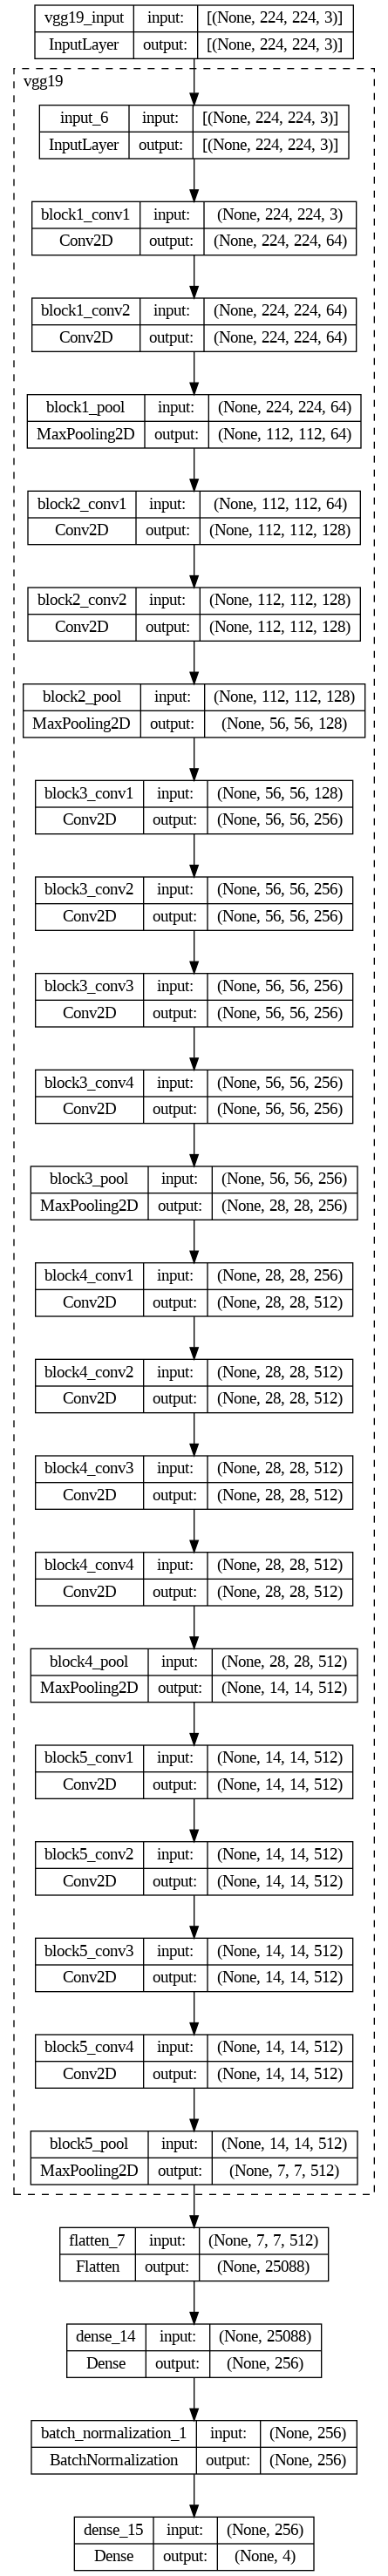

In [158]:
tf.keras.utils.plot_model(model2,
                          to_file="/content/drive/MyDrive/OCULAR_DISEASE/model_files/VGG19/VGG_19_model.png",
                          show_shapes=True,
                          expand_nested=True)

In [159]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("/content/drive/MyDrive/OCULAR_DISEASE/model_files/VGG19/vgg19_model.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [160]:
history2 = model2.fit(
    train_data,
    batch_size=32,
    epochs=30,
    validation_data=valid_data,
    verbose=1,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/30
106/106 [==============================] - ETA: 0s - loss: 0.4743 - accuracy: 0.8245
Epoch 1: val_accuracy improved from -inf to 0.90273, saving model to /content/drive/MyDrive/OCULAR_DISEASE/model_files/VGG19/vgg19_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


106/106 [==============================] - 38s 347ms/step - loss: 0.4743 - accuracy: 0.8245 - val_loss: 0.2759 - val_accuracy: 0.9027
Epoch 2/30
106/106 [==============================] - ETA: 0s - loss: 0.1921 - accuracy: 0.9289
Epoch 2: val_accuracy improved from 0.90273 to 0.91696, saving model to /content/drive/MyDrive/OCULAR_DISEASE/model_files/VGG19/vgg19_model.h5
106/106 [==============================] - 37s 345ms/step - loss: 0.1921 - accuracy: 0.9289 - val_loss: 0.2286 - val_accuracy: 0.9170
Epoch 3/30
106/106 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9591
Epoch 3: val_accuracy did not improve from 0.91696
106/106 [==============================] - 36s 334ms/step - loss: 0.1231 - accuracy: 0.9591 - val_loss: 0.2712 - val_accuracy: 0.8921
Epoch 4/30
106/106 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.9748
Epoch 4: val_accuracy did not improve from 0.91696
106/106 [==============================] - 35s 325ms/step - loss:

In [161]:
# Load the saved best model
best_model = tf.keras.models.load_model('/content/drive/MyDrive/OCULAR_DISEASE/model_files/VGG19/vgg19_model.h5')

# Evaluate the best model
loss, accuracy = best_model.evaluate(valid_data)

# Print the results for the best model
print("Best Model Loss:", loss)
print("Best Model Accuracy:", accuracy)

27/27 [==============================] - 7s 261ms/step - loss: 0.2286 - accuracy: 0.9170
Best Model Loss: 0.22860698401927948
Best Model Accuracy: 0.9169632196426392


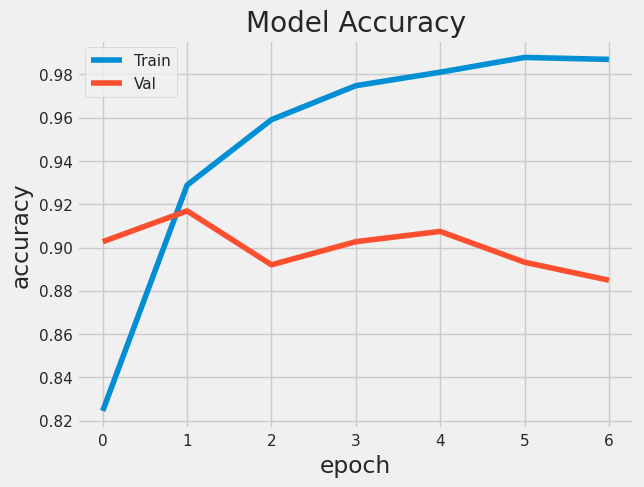

In [162]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

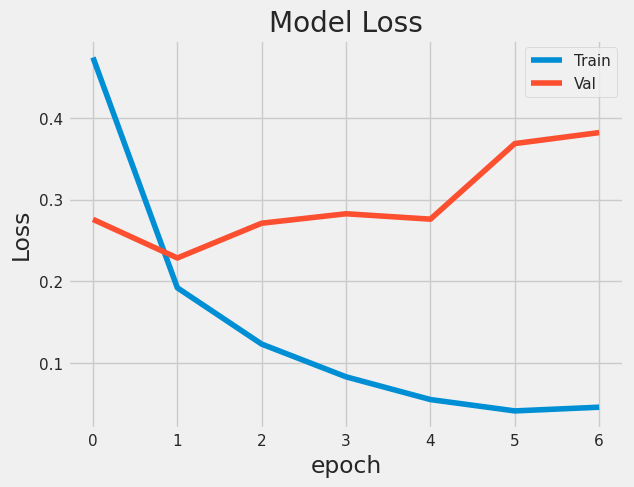

In [163]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

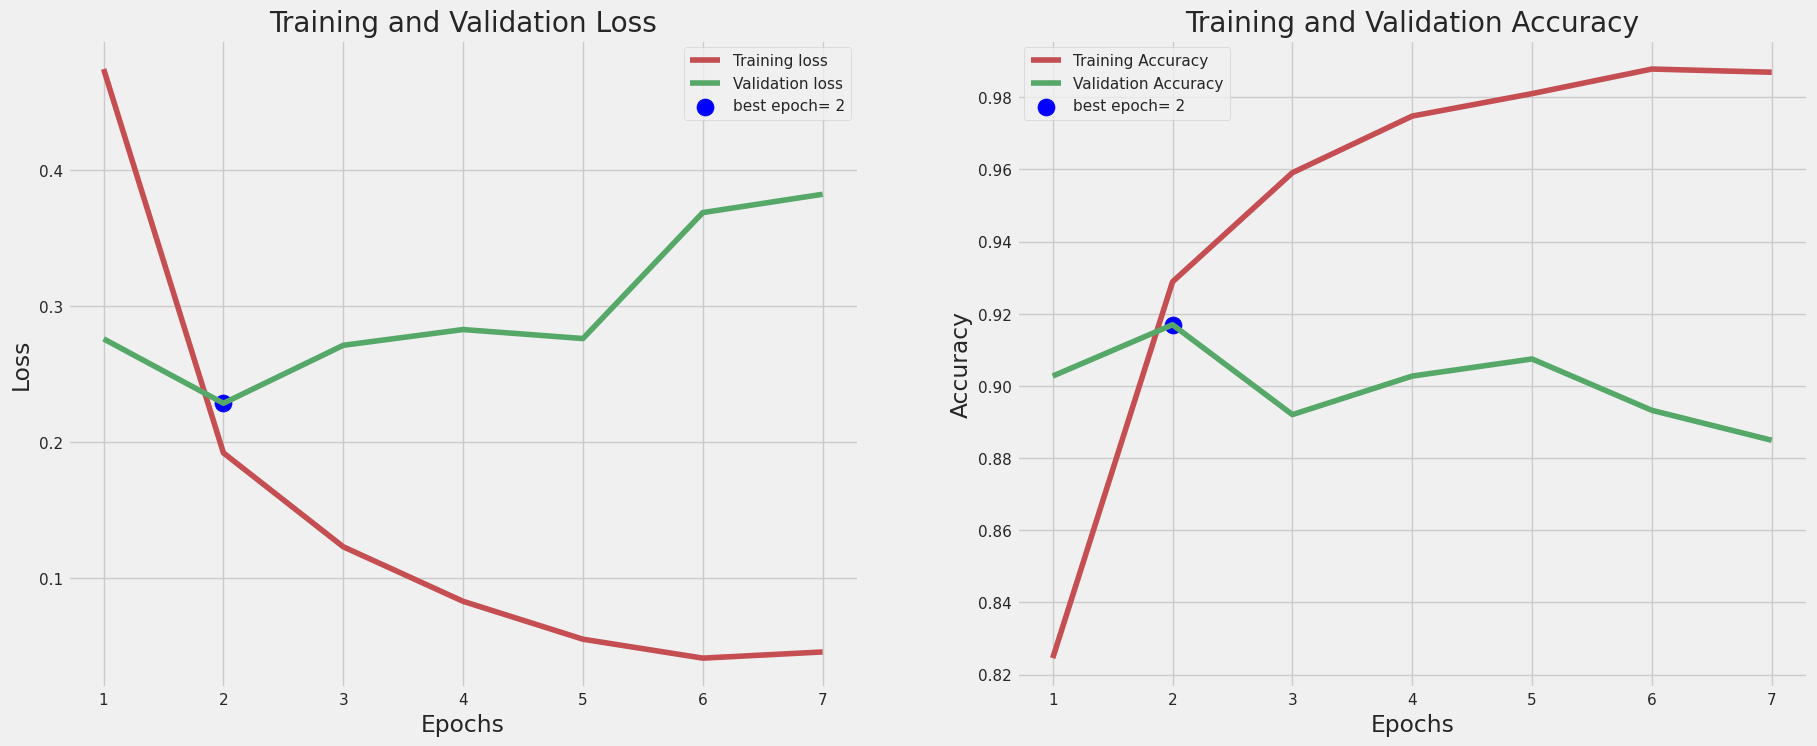

<Figure size 640x480 with 0 Axes>

In [164]:
# plot the history
tr_plot(history2,0)
plt.savefig('/content/drive/MyDrive/OCULAR_DISEASE/model_files/VGG19/VGG_19_history.png')

# VGG19 EVALUATION

In [165]:
y_test = valid_data.classes
y_pred2 = model2.predict(valid_data)
y_pred2 = np.argmax(y_pred2,axis=1)

27/27 [==============================] - 7s 258ms/step


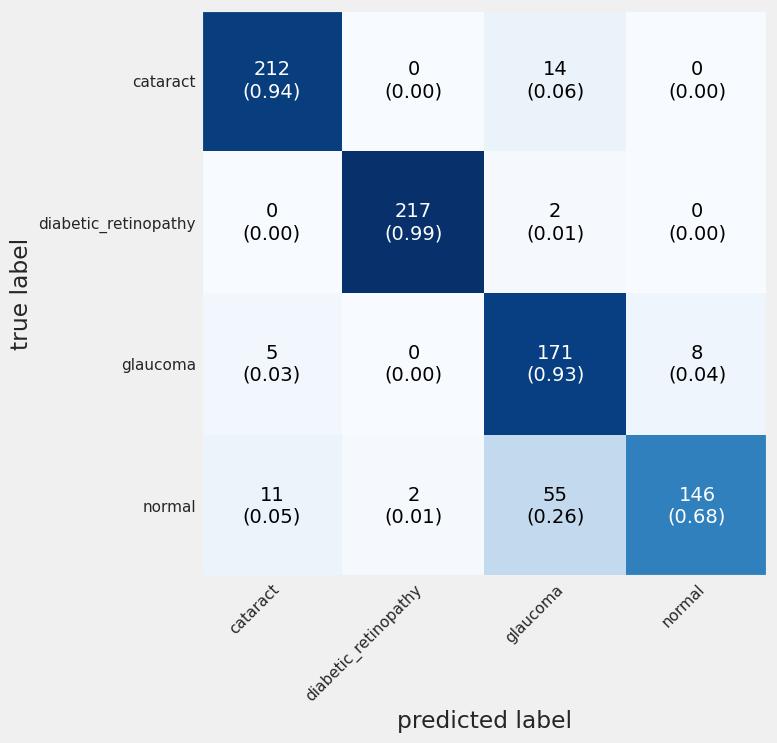

In [166]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred2)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"],
                      show_normed = True);
plt.savefig("/content/drive/MyDrive/OCULAR_DISEASE/model_files/VGG19/vgg_19 Predected & True Label")

In [167]:
print(classification_report(y_test,y_pred2,target_names = labels))

                      precision    recall  f1-score   support

            cataract       0.93      0.94      0.93       226
diabetic_retinopathy       0.99      0.99      0.99       219
            glaucoma       0.71      0.93      0.80       184
              normal       0.95      0.68      0.79       214

            accuracy                           0.88       843
           macro avg       0.89      0.89      0.88       843
        weighted avg       0.90      0.88      0.88       843



1/1 [==============================] - 0s 184ms/step


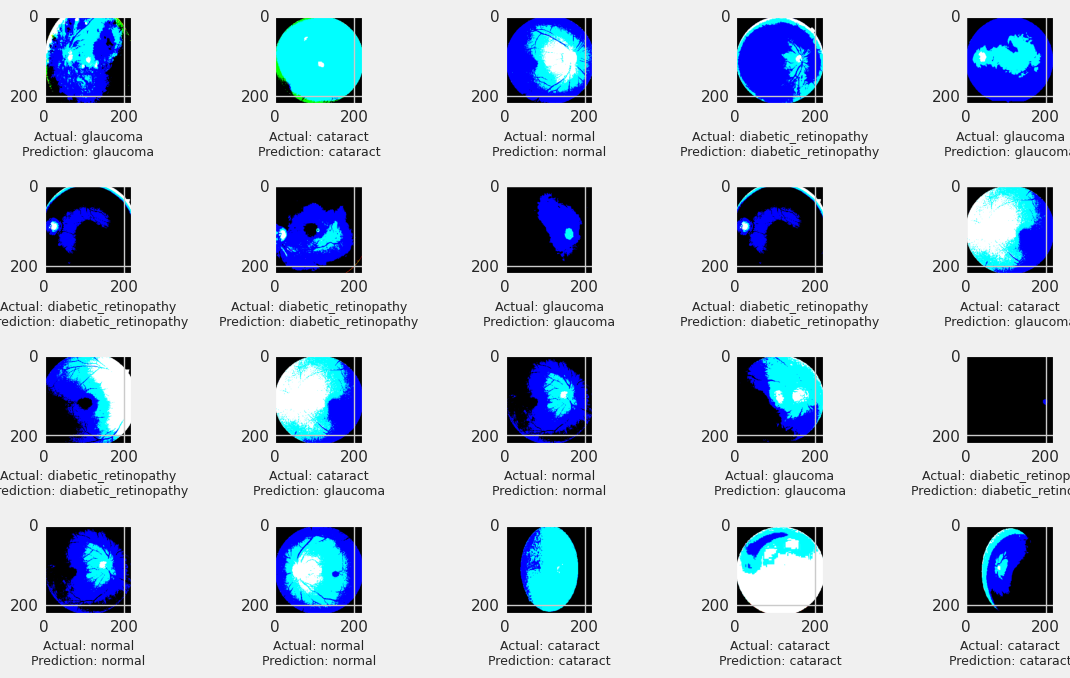

In [168]:
import random
import matplotlib.pyplot as plt


class_labels = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]


images, labels = next(valid_data)


y_pred2 = model2.predict(images)

plt.figure(figsize=(12, 7))

for i in range(20):
    sample_index = random.randint(0, images.shape[0] - 1)
    image = images[sample_index]
    category_index = labels[sample_index].argmax()
    pred_category_index = y_pred2[sample_index].argmax()

    label = class_labels[category_index]
    pred_label = class_labels[pred_category_index]

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)


    plt.xlabel("Actual: {}\nPrediction: {}".format(label, pred_label), fontsize=9)

plt.tight_layout()


plt.savefig('/content/drive/MyDrive/OCULAR_DISEASE/model_files/vgg19 Model Eval.png')

plt.show()

# COMPARISION

In [169]:
accloss = {'Model':['MOBILENET V2','EFFICIENT CNN','VGG19'],
           'Training_Accuracy':[max(history.history['accuracy']),max(history1.history['accuracy']),max(history2.history['accuracy'])],
           'Training_Loss':[min(history.history['loss']),min(history1.history['loss']),min(history2.history['loss'])],
           'Validation_Accuracy':[max(history.history['val_accuracy']),max(history1.history['val_accuracy']),max(history2.history['val_accuracy'])],
           'Validation_Loss':[min(history.history['val_loss']),min(history1.history['val_loss']),min(history2.history['val_loss'])]}

In [170]:
accloss

{'Model': ['MOBILENET V2', 'EFFICIENT CNN', 'VGG19'],
 'Training_Accuracy': [0.9979252815246582,
  0.9931831359863281,
  0.9878482222557068],
 'Training_Loss': [0.013738203793764114,
  0.024356668815016747,
  0.04126998782157898],
 'Validation_Accuracy': [0.8505337834358215,
  0.8801897764205933,
  0.9169632196426392],
 'Validation_Loss': [0.4622221291065216,
  0.4062348008155823,
  0.22860698401927948]}

In [171]:
comp = pd.DataFrame.from_dict(accloss)
comp

Model  Training_Accuracy  Training_Loss  Validation_Accuracy  \
0   MOBILENET V2           0.997925       0.013738             0.850534   
1  EFFICIENT CNN           0.993183       0.024357             0.880190   
2          VGG19           0.987848       0.041270             0.916963   

   Validation_Loss  
0         0.462222  
1         0.406235  
2         0.228607

# ATTENTION MECHANISM ON VGG19 MODEL

In [176]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your data augmentation strategy
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a ChannelAttention layer
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.dense1 = Dense(units=input_shape[-1] // self.reduction_ratio, activation="relu", use_bias=False)
        self.dense2 = Dense(units=input_shape[-1], activation="sigmoid", use_bias=False)

    def call(self, inputs):
        # Global average pooling
        gap = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        channel_att = self.dense1(gap)
        channel_att = self.dense2(channel_att)
        return inputs * channel_att

# Load VGG19 model and unfreeze the last convolutional block
image_size = 224
labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
for layer in vgg.layers[:-4]:  # Unfreeze the last 4 layers
    layer.trainable = False
for layer in vgg.layers[-4:]:
    layer.trainable = True

# Create a new model with attention
input_tensor = Input(shape=(image_size, image_size, 3))
x = vgg(input_tensor)
x = ChannelAttention()(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout
x = Dense(num_classes, activation="softmax")(x)

model_with_attention_VGG19 = Model(inputs=input_tensor, outputs=x)

# Compile with a possibly smaller learning rate
model_with_attention_VGG19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                                   loss='categorical_crossentropy',
                                   metrics=['accuracy'])



# Summarize the model
model_with_attention_VGG19.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 channel_attention_1 (Chann  (None, 7, 7, 512)         65536     
 elAttention)                                                    
                                                                 
 flatten_9 (Flatten)         (None, 25088)             0         
                                                                 
 dense_18 (Dense)            (None, 256)               6422784   
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                          

In [177]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("/content/drive/MyDrive/OCULAR_DISEASE/model_files/VGG19/VGG_19_ATTENTION.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [178]:
history3 = model_with_attention_VGG19.fit(
    train_data,       # Training data
    batch_size=32,    # Batch size for training
    epochs=30,        # Number of training epochs
    validation_data=valid_data,  # Validation data
    verbose=1,        # Verbosity level for training logs
    callbacks=[checkpoint, earlystop]  # Callback functions
)


Epoch 1/30
106/106 [==============================] - ETA: 0s - loss: 1.0288 - accuracy: 0.6322
Epoch 1: val_accuracy improved from -inf to 0.83630, saving model to /content/drive/MyDrive/OCULAR_DISEASE/model_files/VGG19/VGG_19_ATTENTION.h5
106/106 [==============================] - 40s 349ms/step - loss: 1.0288 - accuracy: 0.6322 - val_loss: 0.4598 - val_accuracy: 0.8363
Epoch 2/30
106/106 [==============================] - ETA: 0s - loss: 0.5068 - accuracy: 0.8130
Epoch 2: val_accuracy improved from 0.83630 to 0.88138, saving model to /content/drive/MyDrive/OCULAR_DISEASE/model_files/VGG19/VGG_19_ATTENTION.h5
106/106 [==============================] - 38s 350ms/step - loss: 0.5068 - accuracy: 0.8130 - val_loss: 0.3240 - val_accuracy: 0.8814
Epoch 3/30
106/106 [==============================] - ETA: 0s - loss: 0.3691 - accuracy: 0.8663
Epoch 3: val_accuracy improved from 0.88138 to 0.89798, saving model to /content/drive/MyDrive/OCULAR_DISEASE/model_files/VGG19/VGG_19_ATTENTION.h5
106

In [185]:
# Load the saved best model


# Evaluate the best model
loss, accuracy = model_with_attention_VGG19.evaluate(valid_data)

# Print the results for the best model
print("Loss:", loss)
print("Accuracy:", accuracy)

27/27 [==============================] - 7s 264ms/step - loss: 0.2299 - accuracy: 0.9324
Loss: 0.2299475222826004
Accuracy: 0.9323843121528625


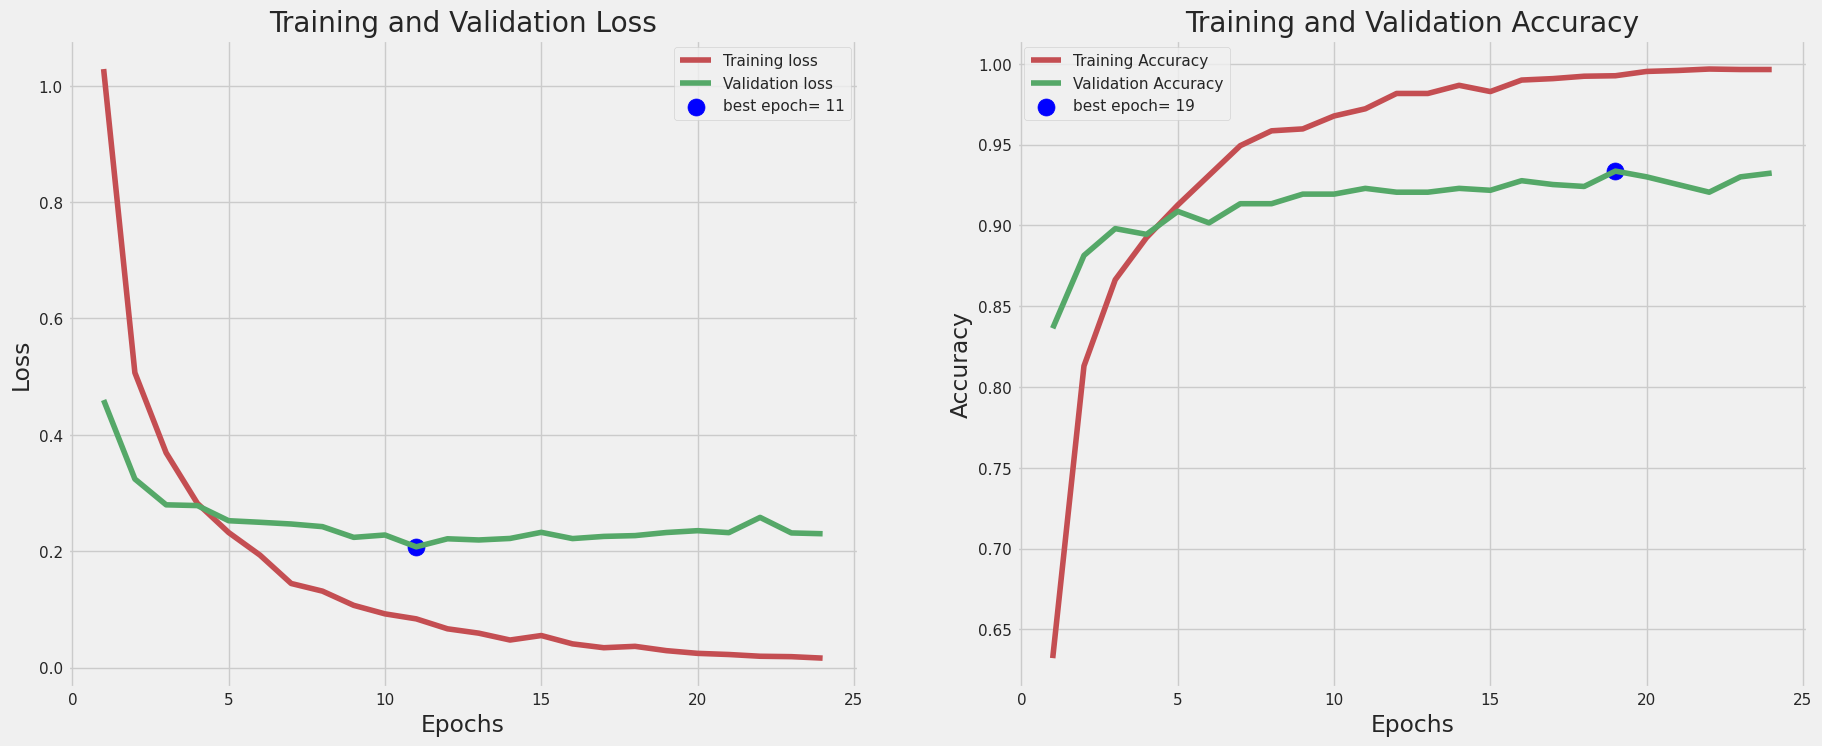

<Figure size 640x480 with 0 Axes>

In [186]:
# plot the history
tr_plot(history,0)
plt.savefig('/content/drive/MyDrive/OCULAR_DISEASE/model_files/VGG19/VGG_19_history_attention.png')

In [187]:
y_test = valid_data.classes
y_pred3 = model_with_attention_VGG19.predict(valid_data)
y_pred3 = np.argmax(y_pred3,axis=1)

27/27 [==============================] - 7s 263ms/step


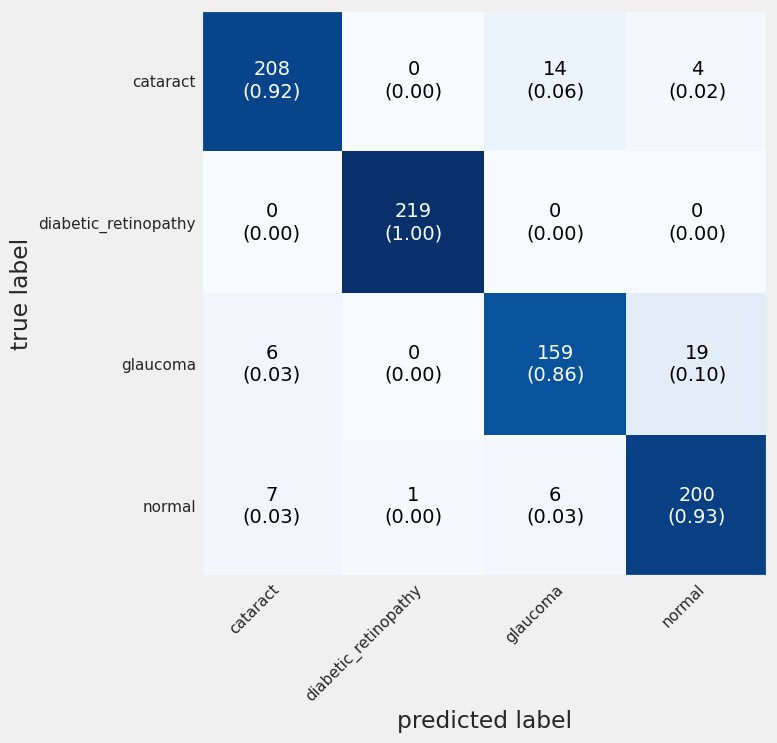

In [188]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred3)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"],
                      show_normed = True);
plt.savefig("/content/drive/MyDrive/OCULAR_DISEASE/model_files/VGG19/vgg_19_with attention Predected & True Label")

In [189]:
print(classification_report(y_test,y_pred3,target_names = labels))

                      precision    recall  f1-score   support

            cataract       0.94      0.92      0.93       226
diabetic_retinopathy       1.00      1.00      1.00       219
            glaucoma       0.89      0.86      0.88       184
              normal       0.90      0.93      0.92       214

            accuracy                           0.93       843
           macro avg       0.93      0.93      0.93       843
        weighted avg       0.93      0.93      0.93       843



1/1 [==============================] - 0s 209ms/step


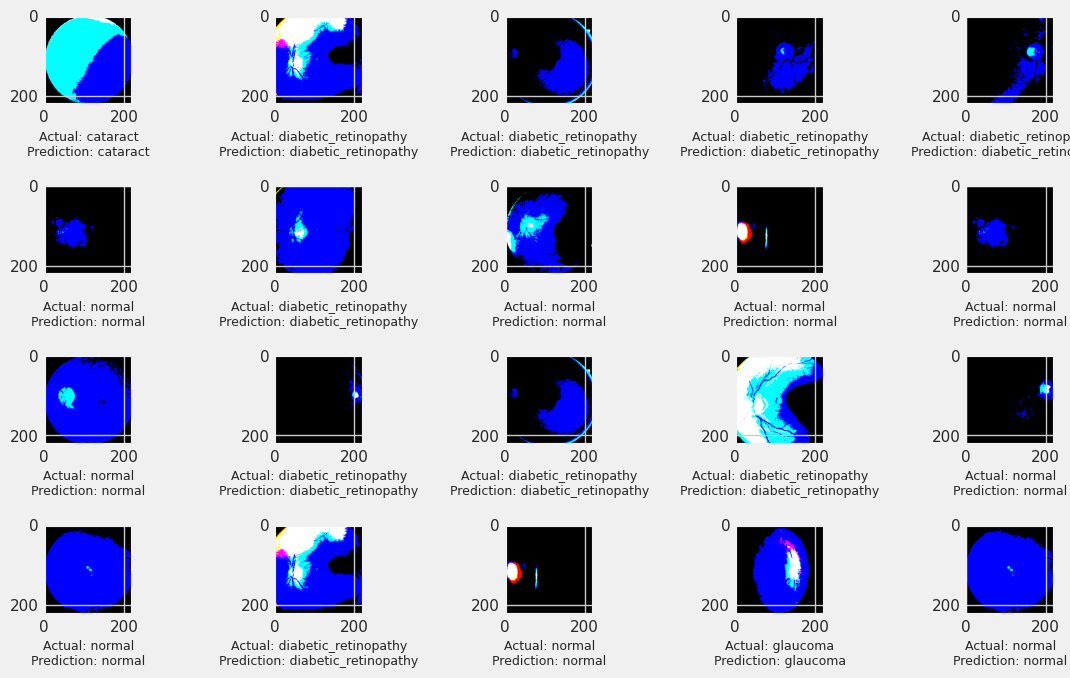

In [190]:
import random
import matplotlib.pyplot as plt


class_labels = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]


images, labels = next(valid_data)


y_pred3 = model_with_attention_VGG19.predict(images)

plt.figure(figsize=(12, 7))

for i in range(20):
    sample_index = random.randint(0, images.shape[0] - 1)
    image = images[sample_index]
    category_index = labels[sample_index].argmax()
    pred_category_index = y_pred3[sample_index].argmax()

    label = class_labels[category_index]
    pred_label = class_labels[pred_category_index]

    plt.subplot(4, 5, i + 1)
    plt.imshow(image)


    plt.xlabel("Actual: {}\nPrediction: {}".format(label, pred_label), fontsize=9)

plt.tight_layout()


plt.savefig('/content/drive/MyDrive/OCULAR_DISEASE/model_files/vgg19_with_attention Model Eval.png')

plt.show()

# PREDICTION

In [192]:
from tensorflow.keras.models import load_model

# Load the trained model
model_path = '/content/drive/MyDrive/OCULAR_DISEASE/model_files/VGG19/vgg19_model.h5'  # Change to your model's filename
model = load_model(model_path)


In [193]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

def preprocess_image(image_path, target_size=(224, 224)):
    # Load image
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    # Preprocess the image
    img_preprocessed = preprocess_input(img_array_expanded)
    return img_preprocessed


In [194]:
def predict_exact_disease(image_path, model):
    preprocessed_image = preprocess_image(image_path)
    # Make predictions
    predictions = model.predict(preprocessed_image)
    # Get the class with the highest probability
    class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma','normal']
    predicted_class = class_names[np.argmax(predictions)]
    predicted_prob = np.max(predictions)
    return predicted_class, predicted_prob

In [195]:
image_path = '/content/drive/MyDrive/dataset/cataract/1083_left.jpg'
predicted_class, predicted_prob = predict_exact_disease(image_path, model)

# Print the predicted class and its probability
print(f"Predicted class: {predicted_class} with probability {predicted_prob:.4f}")

1/1 [==============================] - 1s 732ms/step
Predicted class: cataract with probability 0.7588


In [196]:
image_path = '/content/drive/MyDrive/dataset/diabetic_retinopathy/10058_right.jpeg'
predicted_class, predicted_prob = predict_exact_disease(image_path, model)

# Print the predicted class and its probability
print(f"Predicted class: {predicted_class} with probability {predicted_prob:.4f}")

1/1 [==============================] - 0s 24ms/step
Predicted class: diabetic_retinopathy with probability 1.0000


In [197]:
image_path = '/content/drive/MyDrive/dataset/glaucoma/1269_left.jpg'
predicted_class, predicted_prob = predict_exact_disease(image_path, model)

# Print the predicted class and its probability
print(f"Predicted class: {predicted_class} with probability {predicted_prob:.4f}")

1/1 [==============================] - 0s 24ms/step
Predicted class: glaucoma with probability 0.9149


In [198]:
image_path = '/content/drive/MyDrive/dataset/normal/2334_left.jpg'
predicted_class, predicted_prob = predict_exact_disease(image_path, model)

# Print the predicted class and its probability
print(f"Predicted class: {predicted_class} with probability {predicted_prob:.4f}")

1/1 [==============================] - 0s 24ms/step
Predicted class: normal with probability 0.9799
